# Обучение RuBERT классификатора (Native PyTorch)

Автор: Синицин Михаил Дмитриевич

Модель: RuBERT для классификации вопросов абитуриентов (8 категорий)

In [1]:
# Установка 
!pip install transformers torch scikit-learn pandas matplotlib seaborn tqdm

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')

Устройство: cpu


In [3]:
# Загрузка датасета
with open('final_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f'Всего примеров: {len(df)}')
print('\nРаспределение по категориям:')
print(df['category'].value_counts())

Всего примеров: 4776

Распределение по категориям:
category
Обучение          1722
Поступление       1133
Общежитие          634
Формы обучения     536
Стоимость          271
Без ЕГЭ            265
Контакты           108
Бюджет             107
Name: count, dtype: int64


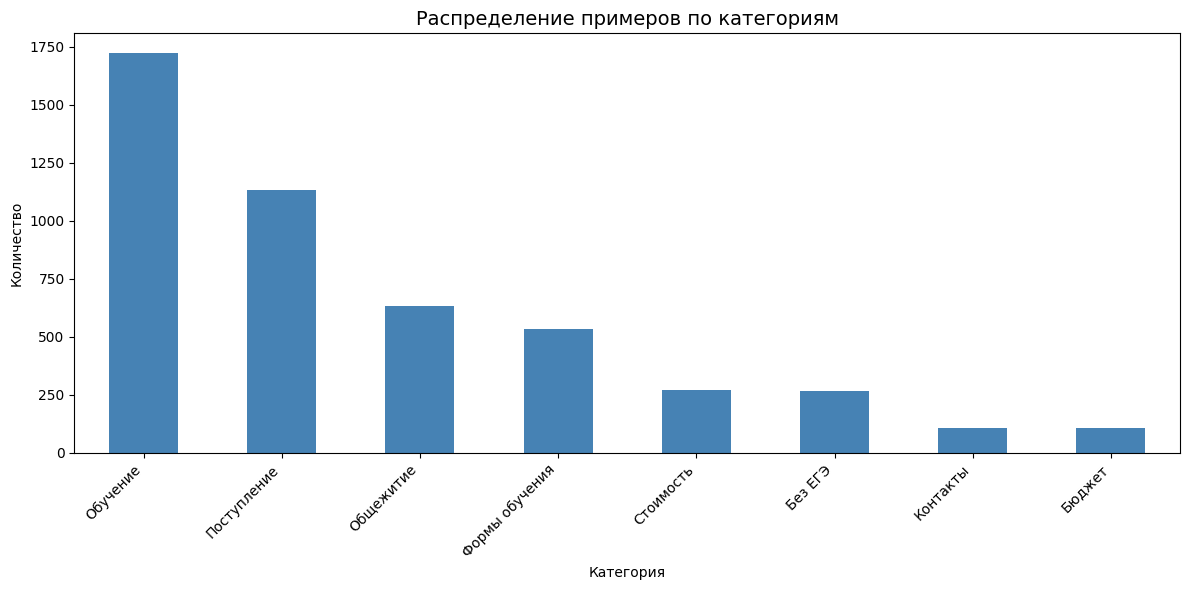

In [4]:
# Визуализация
plt.figure(figsize=(12, 6))
df['category'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Распределение примеров по категориям', fontsize=14)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300)
plt.show()

In [5]:
# Маппинг категорий
categories = sorted(df['category'].unique())
label2id = {label: idx for idx, label in enumerate(categories)}
id2label = {idx: label for label, idx in label2id.items()}
df['label'] = df['category'].map(label2id)

print('Маппинг:')
for idx, label in id2label.items():
    print(f'{idx}: {label}')

with open('label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({'label2id': label2id, 'id2label': id2label}, f, ensure_ascii=False, indent=2)

Маппинг:
0: Без ЕГЭ
1: Бюджет
2: Контакты
3: Обучение
4: Общежитие
5: Поступление
6: Стоимость
7: Формы обучения


In [6]:
# Разделение датасета
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f'Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)')
print(f'Val: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)')
print(f'Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)')

Train: 3343 (70.0%)
Val: 716 (15.0%)
Test: 717 (15.0%)


In [7]:
# Загрузка модели
MODEL_NAME = 'DeepPavlov/rubert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(categories)
).to(device)

print(f'Модель загружена: {sum(p.numel() for p in model.parameters()):,} параметров')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена: 177,859,592 параметров


In [8]:
# Dataset класс
class QuestionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = QuestionDataset(train_df['question'].values, train_df['label'].values, tokenizer)
val_dataset = QuestionDataset(val_df['question'].values, val_df['label'].values, tokenizer)
test_dataset = QuestionDataset(test_df['question'].values, test_df['label'].values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Настройка обучения
learning_rate = 0.00002
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 3

print(f'Epochs: {epochs}')
print(f'Learning rate: {learning_rate}')
print(f'Batch size: 16')

Epochs: 3
Learning rate: 2e-05
Batch size: 16


In [10]:
# Функция для оценки
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_preds, all_labels

In [11]:
# ОБУЧЕНИЕ
import time
start_time = time.time()

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print('Начало обучения...')
print('='*60)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Валидация
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Val Loss: {val_loss:.4f}')
    print(f'  Val Accuracy: {val_acc*100:.2f}%')
    print('='*60)

training_time = time.time() - start_time
print(f'\nОбучение завершено! Время: {training_time:.2f} сек ({training_time/60:.2f} мин)')

Начало обучения...


Epoch 1/3: 100%|██████████| 209/209 [13:28<00:00,  3.87s/it, loss=0.484]



Epoch 1:
  Train Loss: 0.9649
  Val Loss: 0.3852
  Val Accuracy: 87.43%


Epoch 2/3: 100%|██████████| 209/209 [12:41<00:00,  3.64s/it, loss=0.449] 



Epoch 2:
  Train Loss: 0.2439
  Val Loss: 0.1815
  Val Accuracy: 94.69%


Epoch 3/3: 100%|██████████| 209/209 [12:27<00:00,  3.58s/it, loss=0.0721]



Epoch 3:
  Train Loss: 0.1063
  Val Loss: 0.2264
  Val Accuracy: 93.44%

Обучение завершено! Время: 2459.69 сек (40.99 мин)


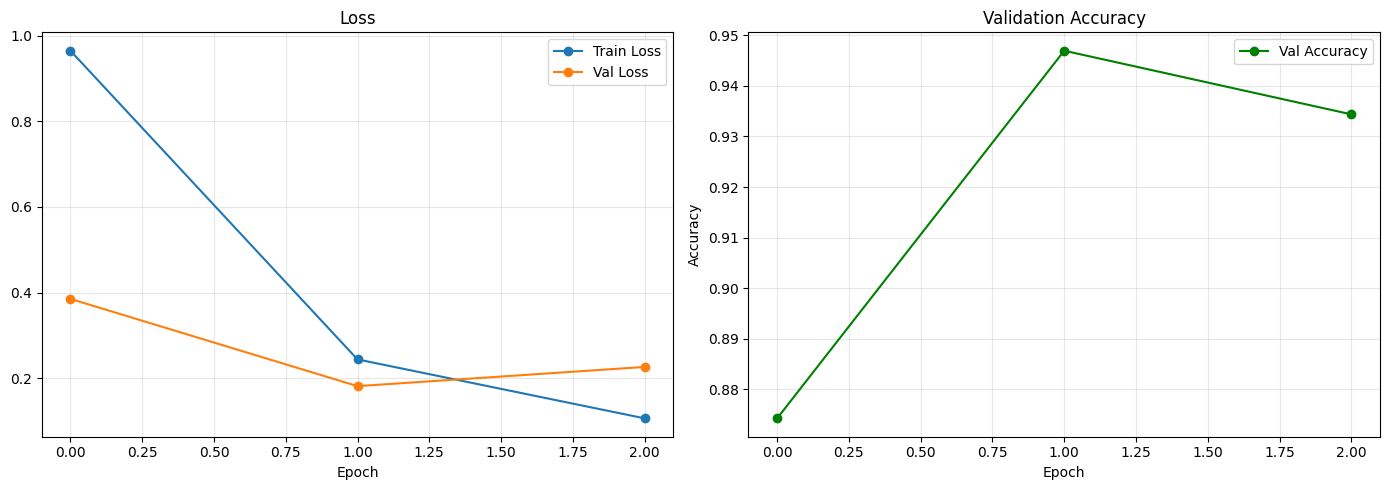

In [12]:
# Графики обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o', color='green')
axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

In [13]:
# Оценка на test set
print('Оценка на тестовой выборке...')
test_loss, test_acc, preds, labels = evaluate(model, test_loader, device)

print(f'\nTest Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

report = classification_report(labels, preds, target_names=categories, digits=4)
print('\nДетальный отчёт:')
print(report)

# Сохранение
with open('evaluation_report.txt', 'w', encoding='utf-8') as f:
    f.write(f'Accuracy: {test_acc*100:.2f}%\n')
    f.write(f'F1-score: {classification_report(labels, preds, output_dict=True)["weighted avg"]["f1-score"]*100:.2f}%\n')
    f.write('\n' + report)

Оценка на тестовой выборке...

Test Accuracy: 93.58%
Test Loss: 0.2243

Детальный отчёт:
                precision    recall  f1-score   support

       Без ЕГЭ     0.7400    0.9250    0.8222        40
        Бюджет     0.7647    0.8125    0.7879        16
      Контакты     1.0000    1.0000    1.0000        16
      Обучение     0.9754    0.9189    0.9463       259
     Общежитие     0.9895    0.9895    0.9895        95
   Поступление     0.9518    0.9294    0.9405       170
     Стоимость     0.9231    0.9000    0.9114        40
Формы обучения     0.8778    0.9753    0.9240        81

      accuracy                         0.9358       717
     macro avg     0.9028    0.9313    0.9152       717
  weighted avg     0.9404    0.9358    0.9369       717



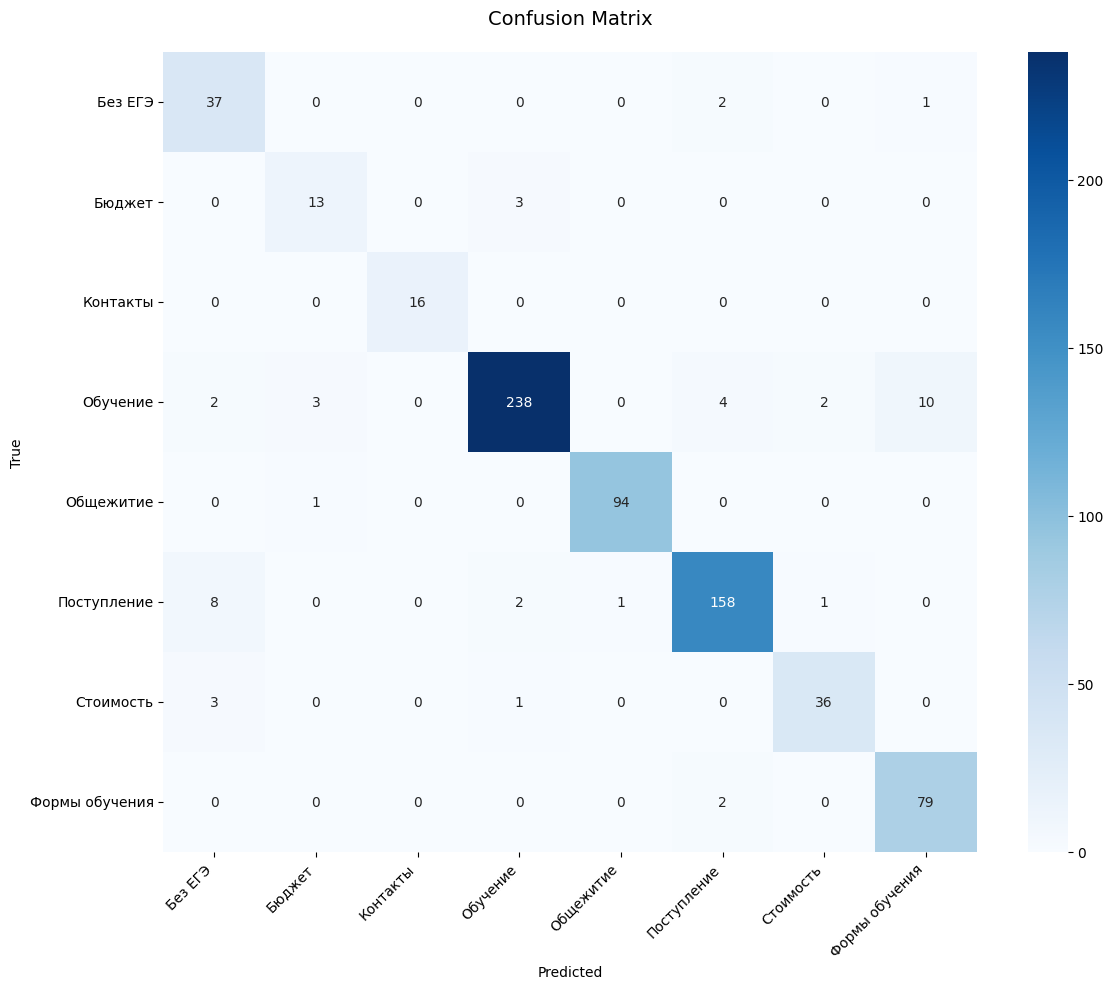

In [14]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

Метрики по категориям:
     Категория  Precision   Recall  F1-Score
       Без ЕГЭ   0.740000 0.925000  0.822222
        Бюджет   0.764706 0.812500  0.787879
      Контакты   1.000000 1.000000  1.000000
      Обучение   0.975410 0.918919  0.946322
     Общежитие   0.989474 0.989474  0.989474
   Поступление   0.951807 0.929412  0.940476
     Стоимость   0.923077 0.900000  0.911392
Формы обучения   0.877778 0.975309  0.923977


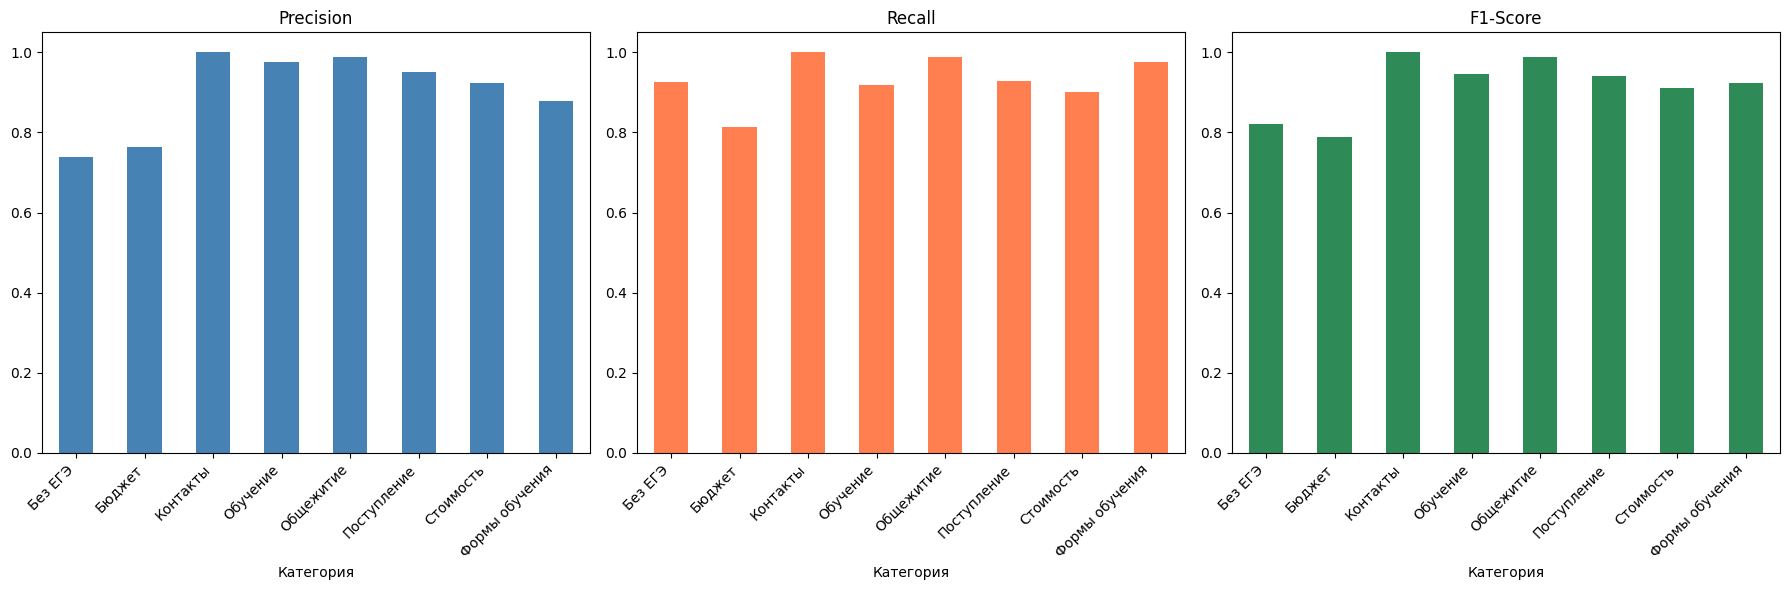

In [15]:
# Метрики по категориям
report_dict = classification_report(labels, preds, target_names=categories, output_dict=True)

metrics_df = pd.DataFrame({
    'Категория': categories,
    'Precision': [report_dict[cat]['precision'] for cat in categories],
    'Recall': [report_dict[cat]['recall'] for cat in categories],
    'F1-Score': [report_dict[cat]['f1-score'] for cat in categories]
})

print('Метрики по категориям:')
print(metrics_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_df.plot(x='Категория', y='Precision', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Precision')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim([0, 1.05])

metrics_df.plot(x='Категория', y='Recall', kind='bar', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Recall')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylim([0, 1.05])

metrics_df.plot(x='Категория', y='F1-Score', kind='bar', ax=axes[2], color='seagreen', legend=False)
axes[2].set_title('F1-Score')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('metrics_by_category.png', dpi=300)
plt.show()

In [16]:
# Сохранение модели
output_dir = './final_model'
import os
os.makedirs(output_dir, exist_ok=True)

print(f'Сохранение модели в {output_dir}...')
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

import shutil
shutil.copy('label_mapping.json', f'{output_dir}/label_mapping.json')

print('Модель сохранена!')

Сохранение модели в ./final_model...
Модель сохранена!


In [17]:
# Тестирование на примерах
def predict(text):
    model.eval()
    encoding = tokenizer(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()
    
    return id2label[pred_idx], confidence

tests = [
    'Сколько стоит обучение на юриста?',
    'Какие документы нужны?',
    'Есть ли бюджетные места?',
    'Можно без ЕГЭ?',
    'Где общежитие?',
    'Какие формы обучения?',
    'Когда приём документов?',
    'Как связаться?'
]

print('\nТестирование:')
print('='*70)
for q in tests:
    cat, conf = predict(q)
    print(f'{q} -> {cat} ({conf*100:.1f}%)')


Тестирование:
Сколько стоит обучение на юриста? -> Обучение (98.3%)
Какие документы нужны? -> Общежитие (55.6%)
Есть ли бюджетные места? -> Бюджет (53.8%)
Можно без ЕГЭ? -> Без ЕГЭ (91.0%)
Где общежитие? -> Общежитие (99.1%)
Какие формы обучения? -> Формы обучения (98.8%)
Когда приём документов? -> Обучение (98.0%)
Как связаться? -> Общежитие (84.5%)


In [18]:
# Итоговая сводка
print('='*60)
print('ИТОГОВЫЕ РЕЗУЛЬТАТЫ')
print('='*60)
print(f'Модель: {MODEL_NAME}')
print(f'Датасет: {len(df)} примеров, {len(categories)} категорий')
print(f'Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}')
print(f'\nAccuracy: {test_acc*100:.2f}%')
print(f'F1-score: {report_dict["weighted avg"]["f1-score"]*100:.2f}%')
print(f'\nВремя обучения: {training_time/60:.2f} минут')
print(f'Epochs: {epochs}')
print(f'Batch size: 16')
print(f'Learning rate: 2e-5')
print('='*60)

summary = {
    'model': MODEL_NAME,
    'dataset_size': len(df),
    'accuracy': float(test_acc),
    'f1_weighted': float(report_dict['weighted avg']['f1-score']),
    'training_time_minutes': training_time/60,
    'epochs': epochs
}

with open('training_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print('\nВсе файлы сохранены!')

ИТОГОВЫЕ РЕЗУЛЬТАТЫ
Модель: DeepPavlov/rubert-base-cased
Датасет: 4776 примеров, 8 категорий
Train/Val/Test: 3343/716/717

Accuracy: 93.58%
F1-score: 93.69%

Время обучения: 40.99 минут
Epochs: 3
Batch size: 16
Learning rate: 2e-5

Все файлы сохранены!
